# Trabalho final de visão Computacional

Alunas: Lara Fischer e Letícia Amanda Cechinel

Semestre: 2022.2

Como proposta para o trabalho final da disciplina, iremos utilizar uma base de dados com a qual poderemos utilizar métodos de visão clássica e recursos de redes neurais para conseguir **classificar** as imagens da referida base. Abaixo você encontrará mais elucidações sobre a base e sua proposta.

Ressaltamos que este trabalho foi construído único e exclusivamente com o fim de ser um processo avaliativo na disciplina INE410121-41000025DO/ME (20222) – Visão Computacional. Além disso, este notebook foi inspirado na construção disponibilizada para a turma cujo título é '11. Exemplo Completo com Visão Clássica'

# Explorando a base de dados

Escolhemos para este projeto a base de dados 'Covid Face-Mask Monitoring Dataset', a qual pode ser encontrada em: https://www.kaggle.com/datasets/jishan900/covid-facemask-monitoring-dataset.

Essa base possui fotos de pessoas andando pelas ruas de Bangladesh, pessoas comuns que são divididas em **três categorias**: **Com máscara**, **Sem máscara** e **Máscara no lugar errado**. A data em que esse dataset foi feito não é precisada pelos autores, portanto não sabemos se essa monitoria dos ambulantes era realmente usada com o objetivo de controle da proliferação da COVID-19. 

Nosso principal **motivação** foi a pandemia pela qual o mundo passou, principalmente no ano de 2020. Sabemos que infelizmente precisamos colocar em nosso 'novo normal' rotinas que nos afastem de viver em um cenário parecido. E uma dessas precauções é o uso de máscara  em locais públicos por pessoas que estão acometidas de alguma forma por doenças contagiosas.

Dessa maneira, o desenvolvimento de ferramentas que nos proporcionem esse tipo de monitoramento populacional deve ser cada vez mais explorado nos próximos anos. Nesse sentido, nosso trabalho também é de relevância, pois ao desenvolver abordagens usando métodos clássicos facilitamos que esses algoritmos sejam embarcados em câmeras de vigilância por exemplo; apesar de esse não ter sido um dos objetivos de nosso trabalho.

####Características da base:

- Ao todo são 6 550 imagens. Ele já é dividio entre conjunto de treinamento e validação, sendo 5 750 imagens para treino e 800 imagens para o conjunto de validação.
- As imagens possuem dimensão de 1080 x 720.
- Todas são coloridas
- Para obtenção das imagens foi utilisado uma câmera de celular pessoal dos autores

Abaixo segue uma amostra de imagem advinda do dataset
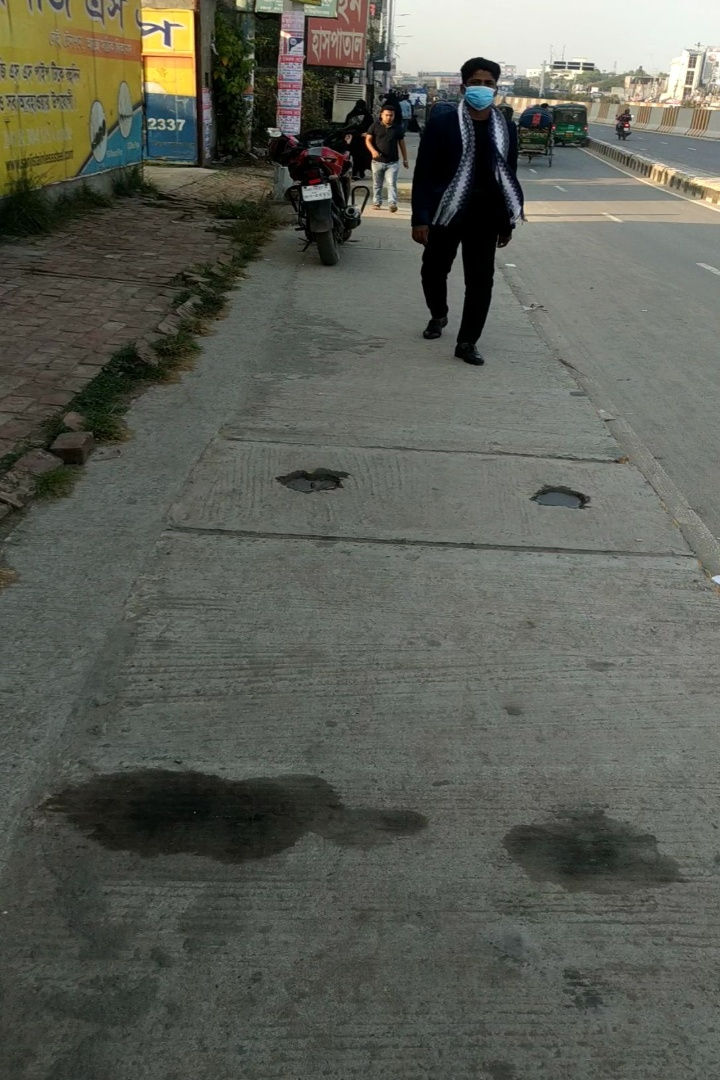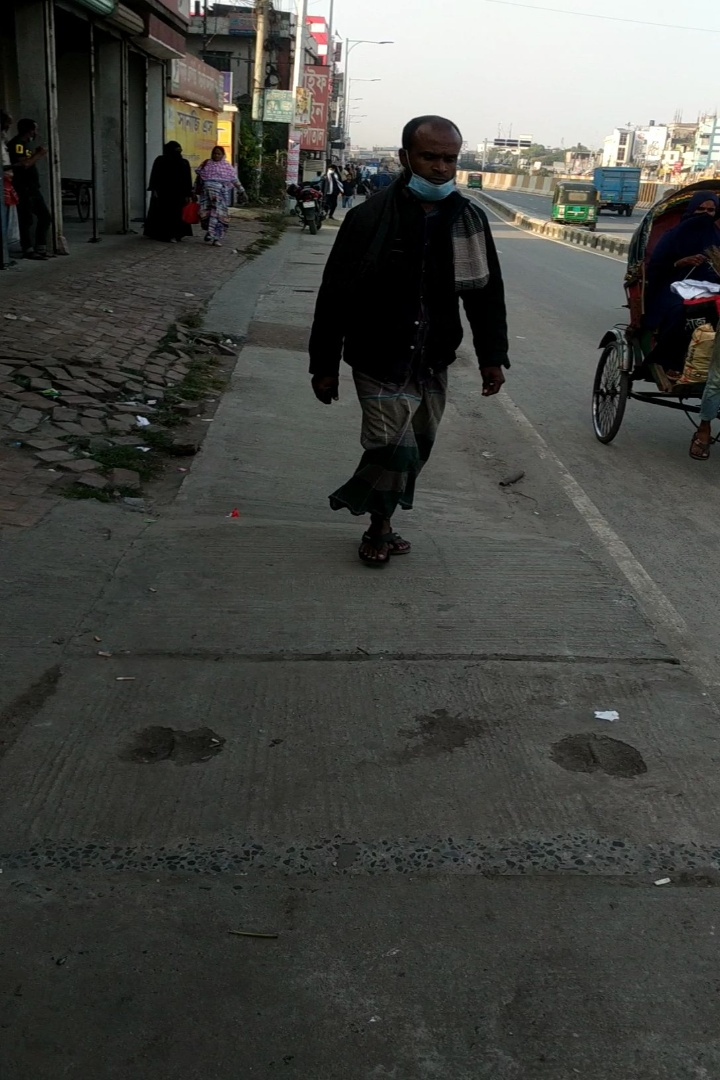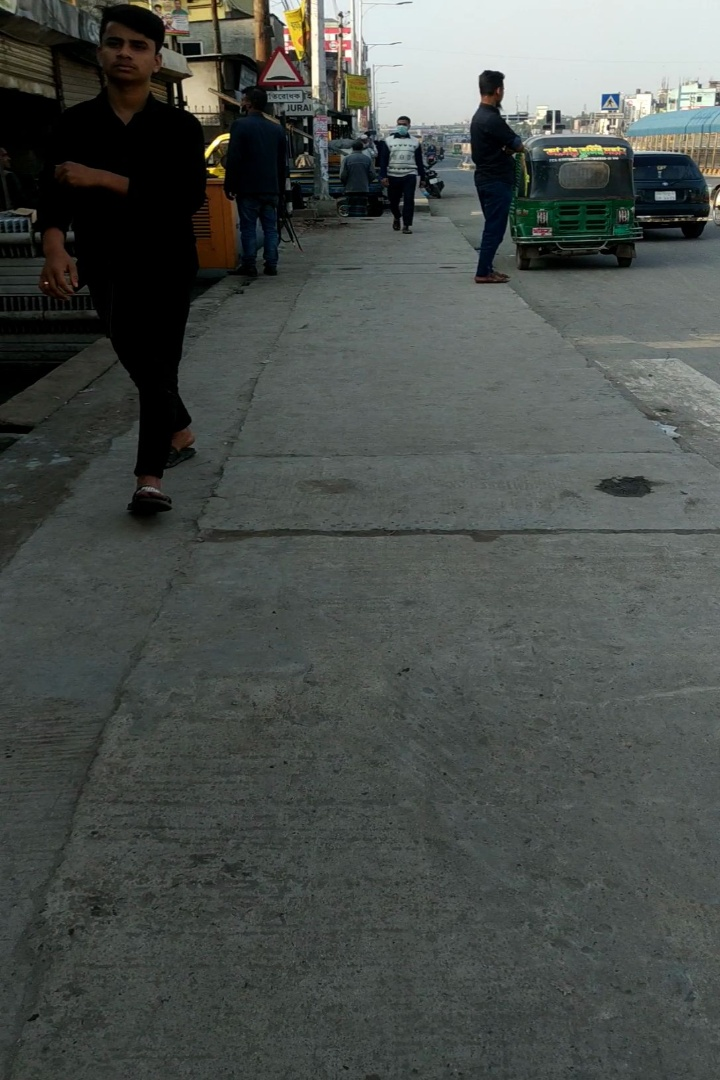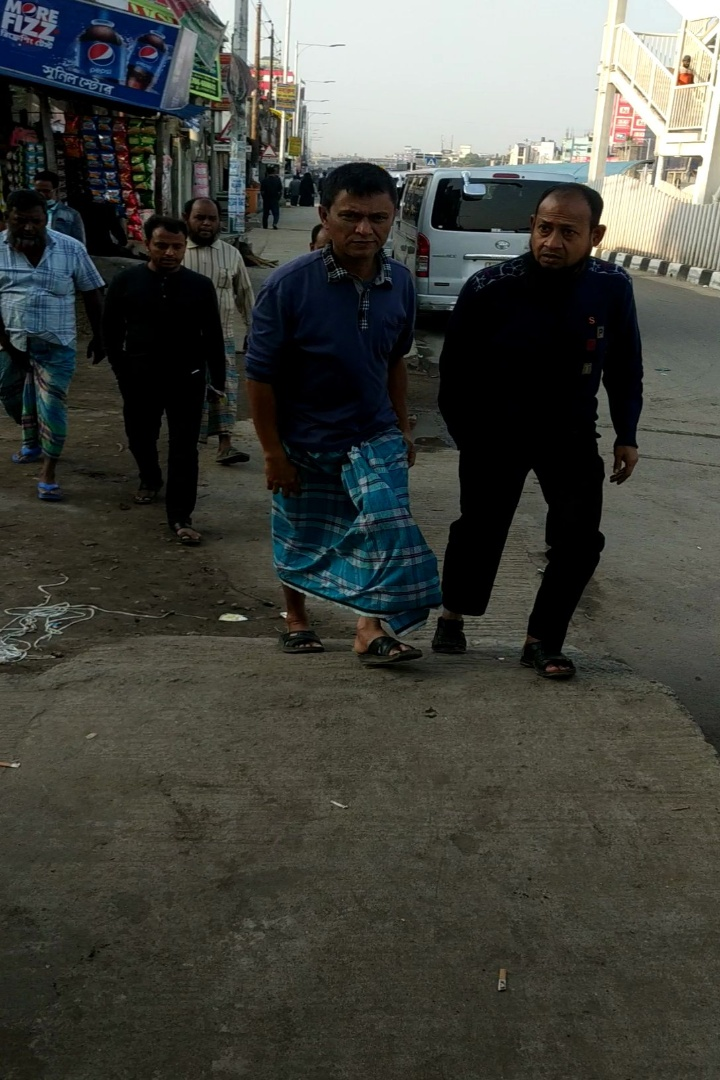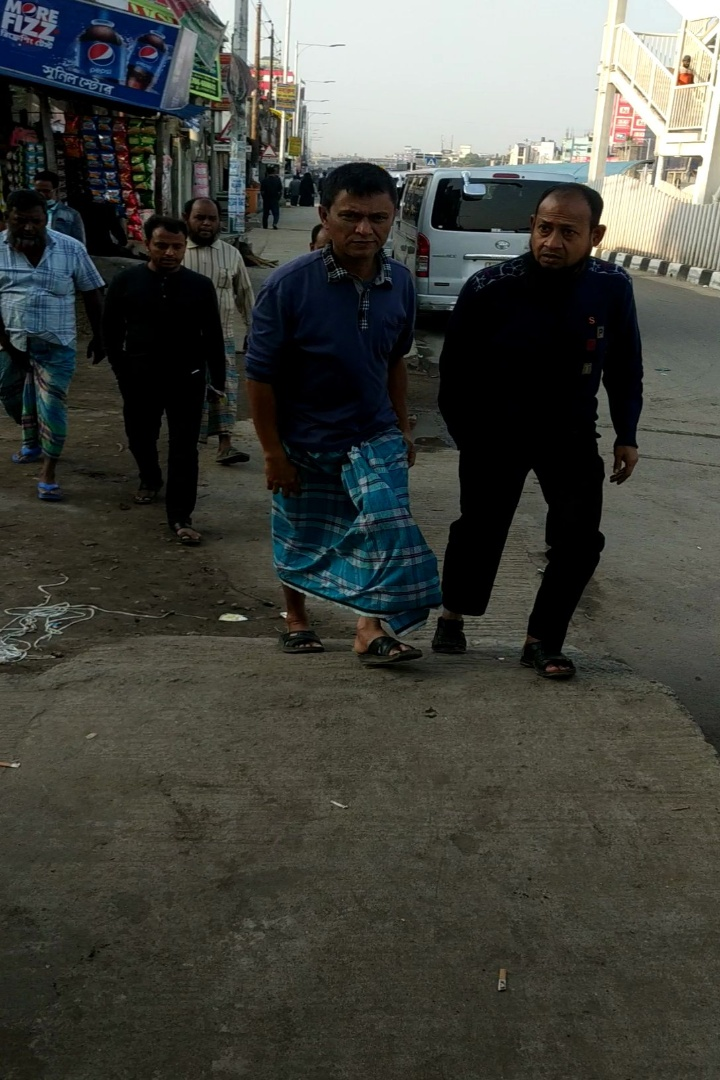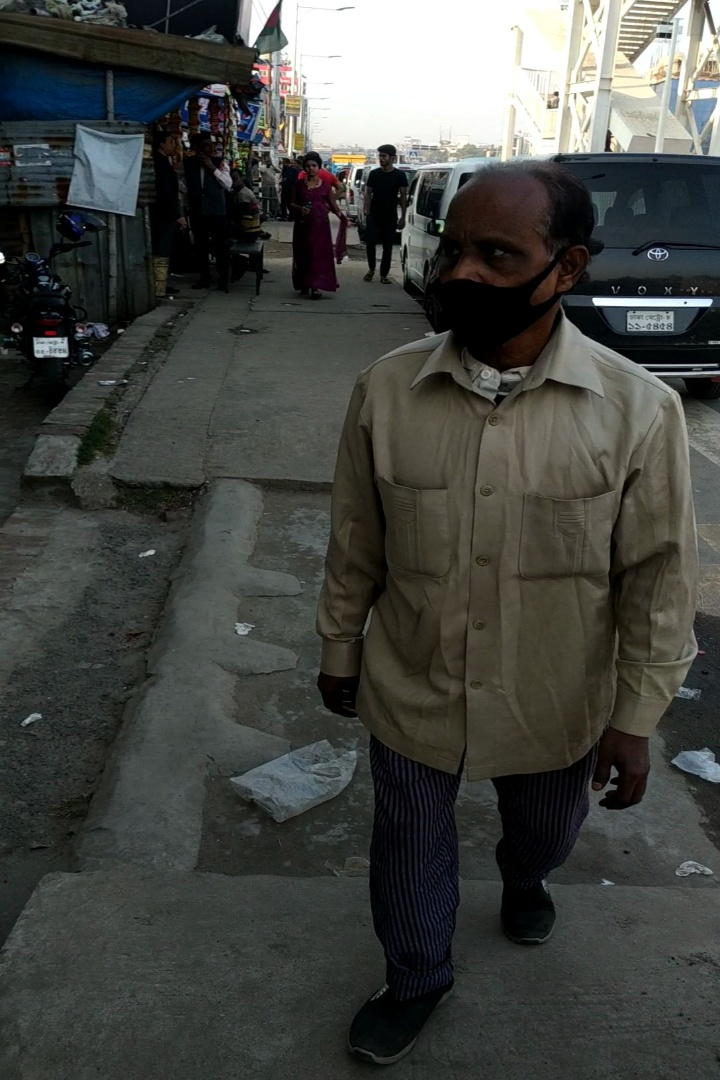

A partir dessa amostra podemos perceber que:

- Muitas fotos são parecidas entre si. Isso se deve ao fato da pessoa que estava fotografando ir andando e retirando as fotos. A mesma cena aparece de outros ângulos conforme a pessoa caminha pelas ruas.
- Mais de uma pessoa pode aparecer por imagem. Isso torna a classificação mais difícil, pois o label de cada imagens não especifica qual das pessoas da imagem que usa ou não a máscara
- Existe muitas cenas de não interesse nas imagens. Isso atrapalha os algoritmos, principalmente os de visão clássica, pois esse 'lixo' ao redor do ponto de interesse desvia o foco do algoritmo. 

Tendo essas características em vista, traçamos a seguinte pipeline:


1.   **Limpar o dataset**. Precisávamos retirar das imagens do dataset original os rostos das pessoas nas três categorias, para facilitar a implementação. Para isso, decidimos utilizar HaarCascades.
2.   **Utilizar visão clássica para resolver o problema**. Optamos por utilizar HoG e testar diferentes algoritmos de classificação ao final.
3. **Utilizar métodos de redes neurais para resolver o problema**



# 1. Pré-processamento

# 2. Enfoque Clássico

Como comentado anteriormente, utilizaremos HoG para realizar a tarefa com visão clássica. Como as classes são desbalanceadas, decidimos reunir as classes de 'Com máscara' e 'Máscara no lugar errado' em uma mesma classe, sendo assim uma classificação binária.

##2.1 Importações

In [ ]:
!pip install xgboost

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# Importações básicas
import os
import cv2
import numpy as np
from skimage import feature

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Definição de variáveis globais básicas
datapath = ("/content/drive/MyDrive/Colab/Visao_Computacional/limpando_a_base/base_limpa_pvf/")

## 2.2 Quantifique vetores característicos usando o HoG Descriptor


In [ ]:
def quantify_image(image, visualize=False):
    if visualize:
        # print('Visualisar HoG!')
        features, hog_image = feature.hog(image, orientations=9,
                               pixels_per_cell=(10, 10), cells_per_block=(2, 2),
                               visualize=visualize,
                               transform_sqrt=True, block_norm="L1")

        return features, hog_image
    else:
        features = feature.hog(image, orientations=9,
                               pixels_per_cell=(10, 10), cells_per_block=(2, 2),
                               transform_sqrt=True, block_norm="L1")

        return features

### 2.2.1. A Função abaixo mostra alguns exemplos de HoG

In [ ]:
import random

In [ ]:
def test_HoG(testingPath):
    # Pega a lista de imagens
    testingPaths = list(paths.list_images(testingPath))
    output_images = []
    # Escolhe 20 imagens a acaso
    for _ in range(20):
        imagePath = random.choice(testingPaths)
        # extract the class label from the filename
        label = imagePath.split(os.path.sep)[-2]
        # print(label)
        image = cv2.imread(imagePath)
        output = image.copy()
        output = cv2.resize(output, (128, 128))
        # pre-process the image
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        image = cv2.resize(image, (200, 200))
        image = cv2.threshold(image, 0, 255,
                              cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)[1]
        # quantify the image and make predictions based on the extracted features
        # lembre-se de incluir o parâmetro opcional visualize=True senão não serão 
        # geradas imagens
        hog, hog_image = quantify_image(image, visualize=True)
        # -----------------------------------------
        # Conversão de float para color
        # 1. Multiplicar por 255
        image = hog_image * 255
        # 2. Truncar para inteiro 8 bits
        hog_image = image.astype(np.uint8)
        # 3. Converter para imagem a cores
        hog_image = cv2.cvtColor(hog_image, cv2.COLOR_GRAY2BGR)
        # ----------------------------------------
        # draw the colored class label on the output image and add it to
        # the set of output images
        color = (255, 255, 0) # if label == "Healthy" else (0, 0, 255)
        cv2.putText(hog_image, label, (3, 20), cv2.FONT_HERSHEY_SIMPLEX, 0.5,
                    color, 2)
        output_images.append(hog_image)
    plt.figure(figsize=(20, 20))
    for i in range(len(output_images)):
        plt.subplot(5, 5, i+1)
        plt.imshow(output_images[i])
        plt.axis("off")
    plt.show()

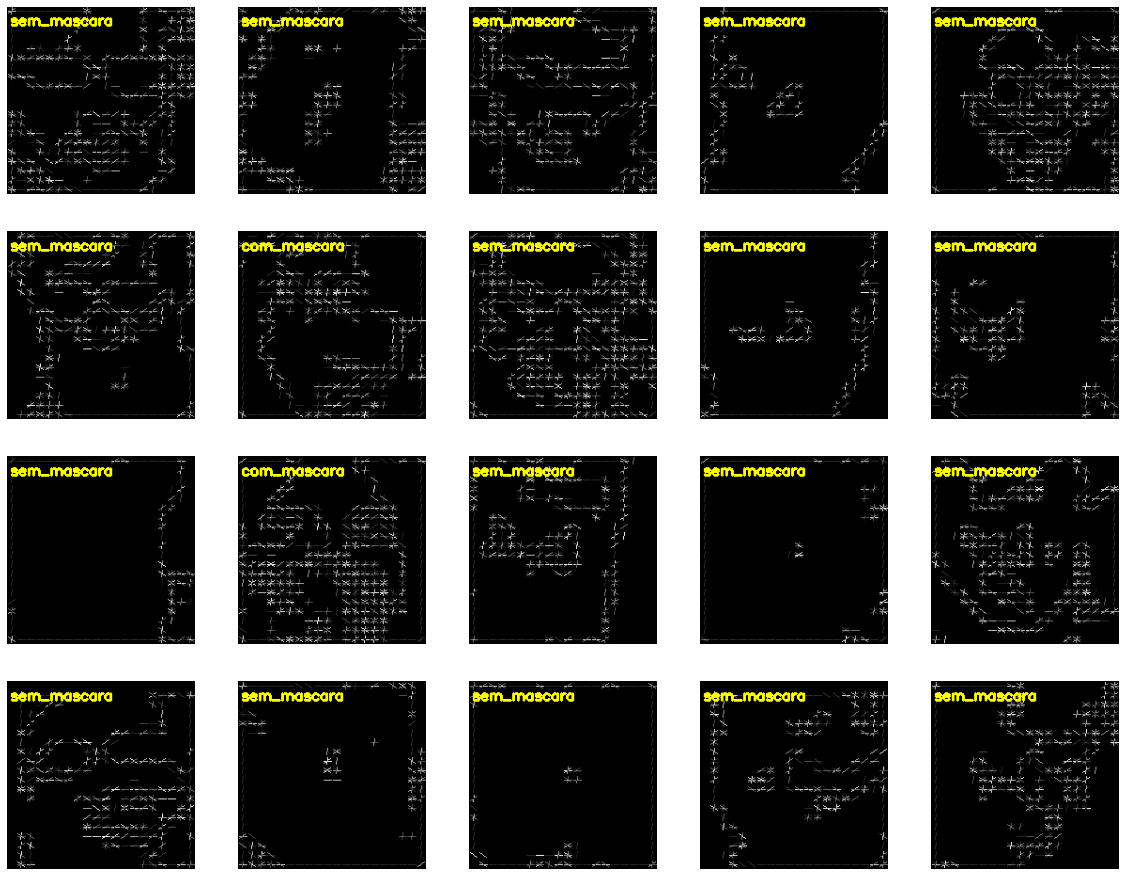

In [ ]:
testingPath = ("/content/drive/MyDrive/Colab/Visao_Computacional/limpando_a_base/base_limpa_pvf/conj_validation/treino/")
test_HoG(testingPath)

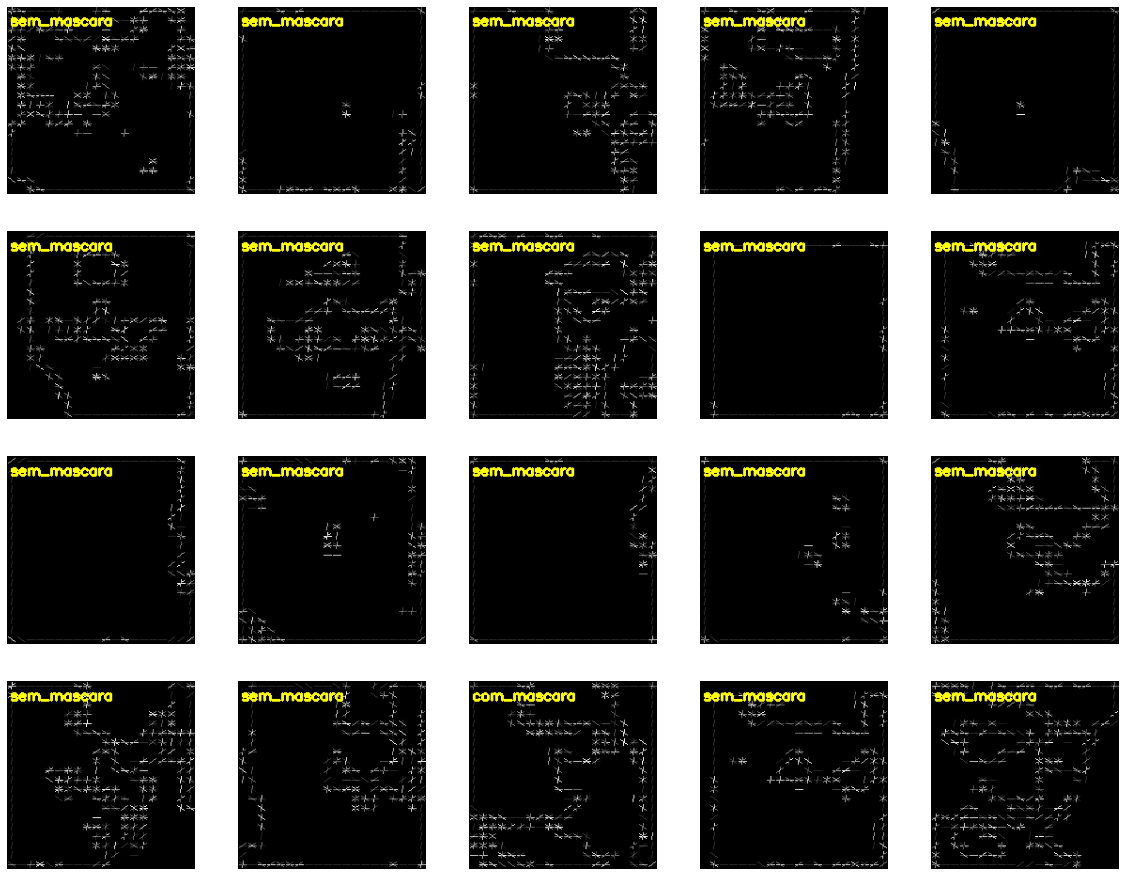

In [ ]:
testingPath = os.path.sep.join([datapath+"/conj_validation", "treino"])
test_HoG(testingPath)

## 2.3 Carregue as imagens e extraia as características com HoG

Vamos aqui definir uma função de carga, preparo e processamento das imagens dos conjuntos de Treino e de Teste. 


In [ ]:
def load_split(path):
    # grab the list of images in the input directory, then initialize
    # the list of data (i.e., images) and class labels
    imagePaths = list(paths.list_images(path))
    print('Encontradas ', len(imagePaths),' imagens em ',path)
    # print('Lista de imagens encontradas:\n', imagePaths)
    data = []
    labels = []
    # loop over the image paths
    for imagePath in imagePaths:
        # extract the class label from the filename
        label = imagePath.split(os.path.sep)[-2]
        # load the input image, convert it to grayscale, and resize
        # it to 200x200 pixels, ignoring aspect ratio
        image = cv2.imread(imagePath)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        image = cv2.resize(image, (200, 200))
        # threshold the image such that the drawing appears as white
        # on a black background
        image = cv2.threshold(image, 0, 255,
                              cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)[1]
        # quantifique a imagem. Aqui usamos o valor default para o parâmetro visualize
        # e assim o parâmetro hog_image não será retornado
        #features, hog_image = quantify_image(image, visualize=True)
        features = quantify_image(image)
        # update the data and labels lists, respectively
        data.append(features)
        labels.append(label)
    return (np.array(data), np.array(labels))

## 2.4 Treinando Métodos de Aprendizado de Máquina Simples

Nós vamos Treinar e Testar os seguintes métodos de Aprendizado de Máquina Clássico:

 * [**Gradient boosting**](https://pt.wikipedia.org/wiki/Gradient_boosting): uma técnica de aprendizado de máquina para problemas de regressão e classificação, que produz um modelo de previsão na forma de um ensemble de modelos de previsão fracos, geralmente árvores de decisão . Ela constrói o modelo em etapas, como outros métodos de boosting, e os generaliza, permitindo a otimização de uma função de perda diferenciável arbitrária. Para isso vamos usar a biblioteca [**Xgboost**](https://pt.wikipedia.org/wiki/Xgboost) - um framework de "gradient boosting" para C++, Java, Python, R e Julia, Perl, e Scala. 
 
 * [**Classificador de Floresta Aleatória**](https://en.wikipedia.org/wiki/Random_forest) ou *Random Forest Classifier* é um método de Aprendizado de Máquina de [*ensemble learning*](https://en.wikipedia.org/wiki/Ensemble_learning) (ou aprendizado por conjunto de classificadores) que irá criar muitas árvores de decisão, de maneira aleatória, formando o que podemos enxergar como uma floresta, onde cada árvore será utilizada na escolha do resultado final, em uma espécie de votação.


 * [**Rede Neural Artificial Backpropagation**](https://en.wikipedia.org/wiki/Feedforward_neural_network) é um método bem conhecido de AM. Usamos a implementação do SKLearn descrita aqui: https://scikit-learn.org/stable/modules/neural_networks_supervised.html
 
 * Referência de kNN do SciKit: https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html Como o kNN está aqui para comparação, vamos usar apenas valores *default* na criação da instância do classificador (*k*=5). 


In [ ]:
from imutils import paths
from sklearn.preprocessing import LabelEncoder

# Importar classificador de floresta aleatória
from sklearn.ensemble import RandomForestClassifier

# Importar classificador de vizinho mais próximo
from sklearn.neighbors import KNeighborsClassifier

# Importar família de classificadores de máquina de vetores de suporte
from sklearn import svm

# Importar classificador de gradient boosting
from xgboost import XGBClassifier

# Importar Rede Neural Artifical BP Clássica
from sklearn.neural_network import MLPClassifier

from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score
import matplotlib.pyplot as plt

### 2.4.1. Função de treinamento

Além de RF e XGB, vamos usar também kNN para termos uma baseline "bobinha" e poder discutir se valeu ou não ser complicado... Além disso vamos também usar SVM e Redes Neurais Artificiais Backpropagation tradicionais. 

Ao todo teremos uma comparação de 5 classificadores "clássicos". 

In [ ]:
def train_models(dataset):
    # initialize the models
    models = {
        # Métodos de ensemble (ou aprendizado por conjunto de classificadores)
        "Rf": {
            "classifier": RandomForestClassifier(random_state=1),
            "accuracy": 0,
            "sensitivity": 0,
            "specificity": 0,
            "auc_score":0,
            "fpr":0,
            "tpr":0,
            "thresh":0
        },
        "Xgb": {
            "classifier": XGBClassifier(),
            "accuracy": 0,
            "sensitivity": 0,
            "specificity": 0,
            "auc_score": 0,
            "fpr":0,
            "tpr":0,
            "thresh":0
        },
        # Método bobinho de vizinho mais próximo para baseline
        "kNN": {
            "classifier": KNeighborsClassifier(weights='distance'),
            "accuracy": 0,
            "sensitivity": 0,
            "specificity": 0,
            "auc_score": 0,
            "fpr":0,
            "tpr":0,
            "thresh":0
        },
         # Máquina de vetores de suporte
        "svm": {
            "classifier": svm.SVC(decision_function_shape='ovo', probability=True),
            "accuracy": 0,
            "sensitivity": 0,
            "specificity": 0,
            "auc_score": 0,
            "fpr":0,
            "tpr":0,
            "thresh":0
        },
         # Rede Neural Artificial BP Clássica
        "ann": {
            "classifier": MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(5, 2), random_state=1),
            "accuracy": 0,
            "sensitivity": 0,
            "specificity": 0,
            "auc_score": 0,
            "fpr":0,
            "tpr":0,
            "thresh":0
        }
    }
    # define the path to the testing and training directories
    # path = "datapath/"+dataset
    path = datapath+dataset
    trainingPath = os.path.sep.join([path, "treino"])
    print('Caminho das imagens de treino:', trainingPath)
    testingPath = os.path.sep.join([path, "teste"])
    print('Caminho das imagens de teste:', testingPath)
    # carregue as imagens de treino
    (trainX, trainY) = load_split(trainingPath)
    # carregue as imagens de teste
    (testX, testY) = load_split(testingPath)
    # codifique os rótulos
    le = LabelEncoder()
    # codifique os rótulos de treino
    trainY = le.fit_transform(trainY)
    # codifique os rótulos de teste
    testY = le.transform(testY)

    # train each model and calculate its metrics
    for model in models:
        print('Treinando modelo: ', model)
        models[model]["classifier"].fit(trainX, trainY)
        predictions = models[model]["classifier"].predict(testX)
        predictions_probs = models[model]["classifier"].predict_proba(testX)
        fpr, tpr, thresh = roc_curve(testY, predictions_probs[:,1])
        models[model]["fpr"] = fpr
        models[model]["tpr"] = tpr
        models[model]["thresh"] = thresh
        cm = confusion_matrix(testY, predictions).ravel()
        tn, fp, fn, tp = cm
        models[model]["accuracy"] = (tp + tn) / float(cm.sum())
        models[model]["sensitivity"] = tp / float(tp + fn)
        models[model]["specificity"] = tn / float(tn + fp)
        models[model]["auc_score"] = roc_auc_score(testY, predictions_probs[:,1])

    return models

### 2.4.2. Curva ROC

A [*Curva Característica de Operação do Receptor* (Curva COR), ou, do inglês, *Receiver Operating Characteristic Curve* (ROC curve), ou, simplesmente, **curva ROC**](https://pt.wikipedia.org/wiki/Caracter%C3%ADstica_de_Opera%C3%A7%C3%A3o_do_Receptor), é uma representação gráfica que ilustra o desempenho (ou performance) de um sistema classificador binário à medida que o seu limiar de discriminação varia. A curva ROC é também conhecida como curva de característica de operação relativa, porque o seu critério de mudança é resultado da operação de duas características (PV e PF). 

In [ ]:
#plot ROC curve
def plot_roc_curve(model, figname):
    plt.style.use("seaborn")
    
    fpr_rf = model["Rf"]["fpr"]
    tpr_rf = model["Rf"]["tpr"]
    auc_score_rf =model["Rf"]["auc_score"]
    
    fpr_xgb = model["Xgb"]["fpr"]
    tpr_xgb = model["Xgb"]["tpr"]
    auc_score_xgb =model["Xgb"]["auc_score"]
    
    fpr_knn = model["kNN"]["fpr"]
    tpr_knn = model["kNN"]["tpr"]
    auc_score_knn =model["kNN"]["auc_score"]
    
    fpr_svm = model["svm"]["fpr"]
    tpr_svm = model["svm"]["tpr"]
    auc_score_svm =model["svm"]["auc_score"]
    
    fpr_ann = model["ann"]["fpr"]
    tpr_ann = model["ann"]["tpr"]
    auc_score_ann =model["ann"]["auc_score"]
    
    plt.figure(figsize=(15, 10))
    plt.title('Receiver Operating Characteristic (ROC curve/sensibility)')
    
    plt.plot(fpr_rf, tpr_rf, color = 'blue', label = 'Random Forest AUC = {:.2f}'.format(auc_score_rf))
#    plt.plot(fpr_xgb, tpr_xgb, color = 'green', label = 'Xgboost AUC = {:.2f}'.format(auc_score_xgb))
    plt.plot(fpr_knn, tpr_knn, color = 'orange', label = 'kNN AUC = {:.2f}'.format(auc_score_knn))
    plt.plot(fpr_svm, tpr_svm, color = 'yellow', label = 'SVM AUC = {:.2f}'.format(auc_score_svm))
    plt.plot(fpr_ann, tpr_ann, color = 'violet', label = 'ANN AUC = {:.2f}'.format(auc_score_svm))
    
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1.1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.savefig(figname, dpi = 300)
    plt.show()

In [ ]:
# Treine os modelos usando os desenhos de espirais
validationModels = train_models('conj_validation')

Caminho das imagens de treino: /content/drive/MyDrive/Colab/Visao_Computacional/limpando_a_base/base_limpa_pvf/conj_validation/treino
Caminho das imagens de teste: /content/drive/MyDrive/Colab/Visao_Computacional/limpando_a_base/base_limpa_pvf/conj_validation/teste
Encontradas  181  imagens em  /content/drive/MyDrive/Colab/Visao_Computacional/limpando_a_base/base_limpa_pvf/conj_validation/treino
Encontradas  79  imagens em  /content/drive/MyDrive/Colab/Visao_Computacional/limpando_a_base/base_limpa_pvf/conj_validation/teste
Treinando modelo:  Rf
Treinando modelo:  Xgb
Treinando modelo:  kNN
Treinando modelo:  svm
Treinando modelo:  ann


## 2.5 Performance dos Modelos

In [ ]:
print("Comparação de classificadores: Random Forest x XGBoost x kNN x SVM x ANN\n")
for metric in ("accuracy", "sensitivity", "specificity", "auc_score"):
    print(f"{metric.capitalize()}: ")
    print("Random Forest={:.2f}%, XGBoost={:.2f}%, kNN={:.2f}%,  svm={:.2f}%,  ann={:.2f}% \n".format(
        validationModels['Rf'][metric]*100, 
        validationModels['Xgb'][metric]*100, 
        validationModels['kNN'][metric]*100, 
        validationModels['svm'][metric]*100,
        validationModels['ann'][metric]*100))

Comparação de classificadores: Random Forest x XGBoost x kNN x SVM x ANN

Accuracy: 
Random Forest=79.75%, XGBoost=75.95%, kNN=79.75%,  svm=79.75%,  ann=79.75% 

Sensitivity: 
Random Forest=100.00%, XGBoost=95.24%, kNN=100.00%,  svm=100.00%,  ann=100.00% 

Specificity: 
Random Forest=0.00%, XGBoost=0.00%, kNN=0.00%,  svm=0.00%,  ann=0.00% 

Auc_score: 
Random Forest=75.20%, XGBoost=68.95%, kNN=57.34%,  svm=76.49%,  ann=50.00% 



#### Lembrando que:

- Verdadeiros Positivos: classificação correta da classe Positivo;
- Falsos Negativos (Erro Tipo II): erro em que o modelo previu a classe Negativo quando o valor real era classe Positivo;
- Falsos Positivos (Erro Tipo I): erro em que o modelo previu a classe Positivo quando o valor real era classe Negativo;
- Verdadeiros Negativos: classificação correta da classe Negativo.
- Acurácia: indica uma performance geral do modelo. Dentre todas as classificações, quantas o modelo classificou corretamente;
- Precisão: dentre todas as classificações de classe Positivo que o modelo fez, quantas estão corretas;
- Recall/Revocação/Sensibilidade: dentre todas as situações de classe Positivo como valor esperado, quantas estão corretas;
- F1-Score: média harmônica entre precisão e recall.

### 2.5.2. Curva ROC

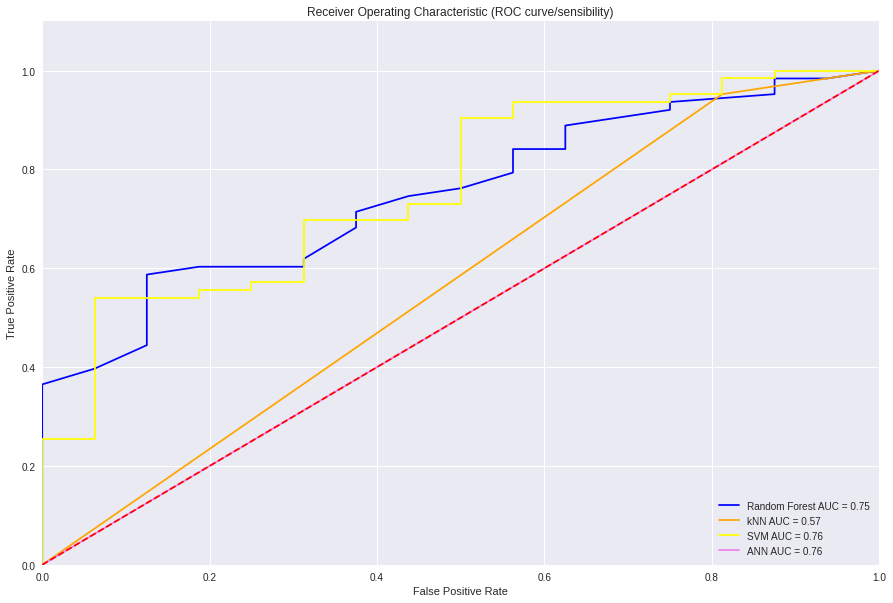

In [ ]:
plot_roc_curve(validationModels, 'spirals')

The Random Forrest Classifier outperforms XGBoost in all cases and across all metrics. With an accuracy of 86.67% in the spiral dataset and 76.67% in the Wave Drawings. Of note is its high specificity 93% and 80% on the spiral and wave datasets respectively

# 3. Testando em Amostras de Imagens

Visualize the predictions

In [ ]:
#import random
import matplotlib.pyplot as plt
%matplotlib inline

Esse comando serve para plotar os gráficos estáticos logo abaixo da célula, existem outras configurações do %matplolib que podem mostrar os gráficos em outras abas ou gráficos dinâmicos.

Por padrão, desde a versão 3.7 do python anaconda, a configuração padrão do %matplotlib já é o inline, por isso você não conseguiu perceber diferenças.

Se quiser testar outras configurações, cheque o link abaixo:

https://ipython.readthedocs.io/en/stable/interactive/plotting.html

## 3.1. Função que realiza predições sobre imagens aleatórias do conjunto de teste:

In [ ]:
def test_prediction(model, testingPath):
    # get the list of images
    testingPaths = list(paths.list_images(testingPath))
    output_images = []
    # Escolha 20 imagens ao acaso
    for _ in range(20):
        image = cv2.imread(random.choice(testingPaths))
        output = image.copy()
        output = cv2.resize(output, (128, 128))
        # pre-process the image
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        image = cv2.resize(image, (200, 200))
        image = cv2.threshold(image, 0, 255,
                              cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)[1]
        # quantify the image and make predictions based on the extracted features
        features, hog_image = quantify_image(image, visualize=True)
        preds = model.predict([features])
        label = "No mask" if preds[0] else "With mask"

        # draw the colored class label on the output image and add it to
        # the set of output images
        color = (0, 200, 0) if label == "With mask" else (255, 0, 0)
        cv2.putText(output, label, (3, 20), cv2.FONT_HERSHEY_SIMPLEX, 0.5,
                    color, 2)
        output_images.append(output)
    plt.figure(figsize=(20, 20))
    for i in range(len(output_images)):
        plt.subplot(5, 5, i+1)
        plt.imshow(output_images[i])
        plt.axis("off")
    plt.show()

## 3.2 Figuras de espirais

Escolha o modelo de Aprendizado de Máquina que você vai usar na segunda linha da célula: 

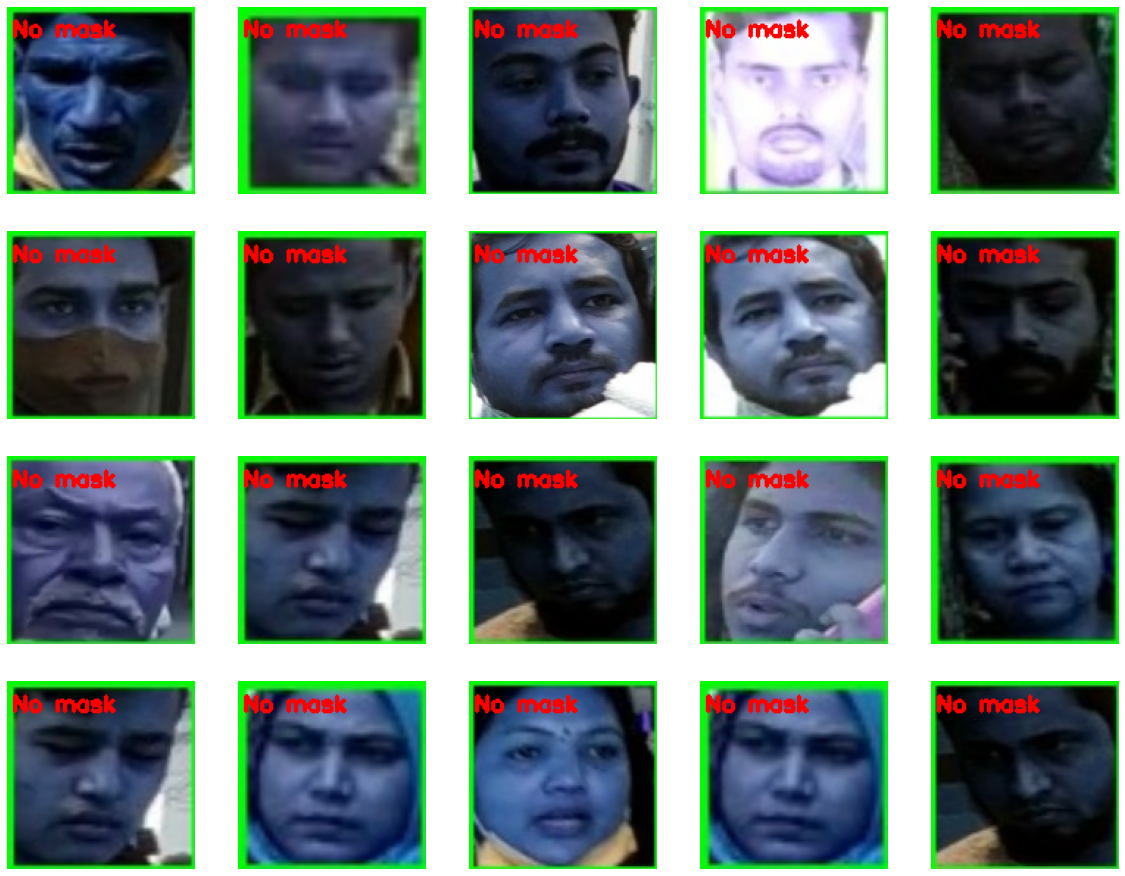

In [ ]:
testingPath = os.path.sep.join([datapath+"/conj_validation", "teste"])
test_prediction(validationModels['Rf']['classifier'], testingPath)

# 4 Save the models for later use

In [ ]:
import joblib

In [ ]:
filename = os.path.join("/content/drive/MyDrive/Colab/Visao_Computacional/HoG_2", "random_forest_validation_model.pkl")
joblib.dump(validationModels['Rf']['classifier'], filename)

['/content/drive/MyDrive/Colab/Visao_Computacional/HoG_2/random_forest_validation_model.pkl']

## 4.1 Test If models have been saved succesfully

In [ ]:
filename = os.path.join("/content/drive/MyDrive/Colab/Visao_Computacional/HoG_2", "random_forest_validation_model.pkl")
validationModels = joblib.load(filename)

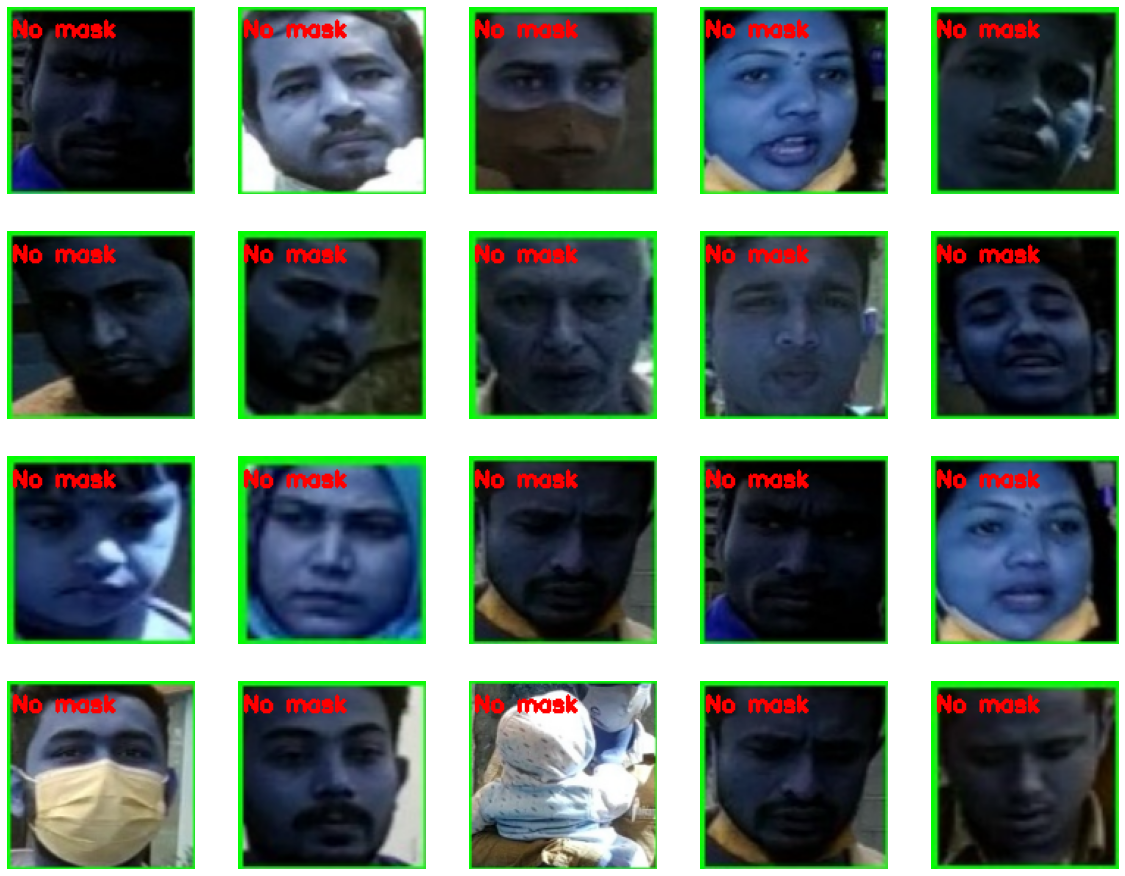

In [ ]:
testingPath = os.path.sep.join(["/content/drive/MyDrive/Colab/Visao_Computacional/limpando_a_base/base_limpa_pvf/conj_validation", "teste"])
test_prediction(validationModels, testingPath)

##### Sucess 😁